In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
get_ipython().magic(u'matplotlib inline')

version = 0.1

df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

df.head(5)

/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [3]:
df.apply(lambda x: x.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
# it seems that PassengerId, Ticket, Cabin aren't very useful, drop them for now
df.drop(['PassengerId','Ticket','Cabin'], inplace=True, axis=1)

In [5]:
df.describe()

/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,NaN,0.000000,0.000000,7.910400
50%,0.000000,3.000000,NaN,0.000000,0.000000,14.454200
75%,1.000000,3.000000,NaN,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10fa3dc10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10fced510>]], dtype=object)

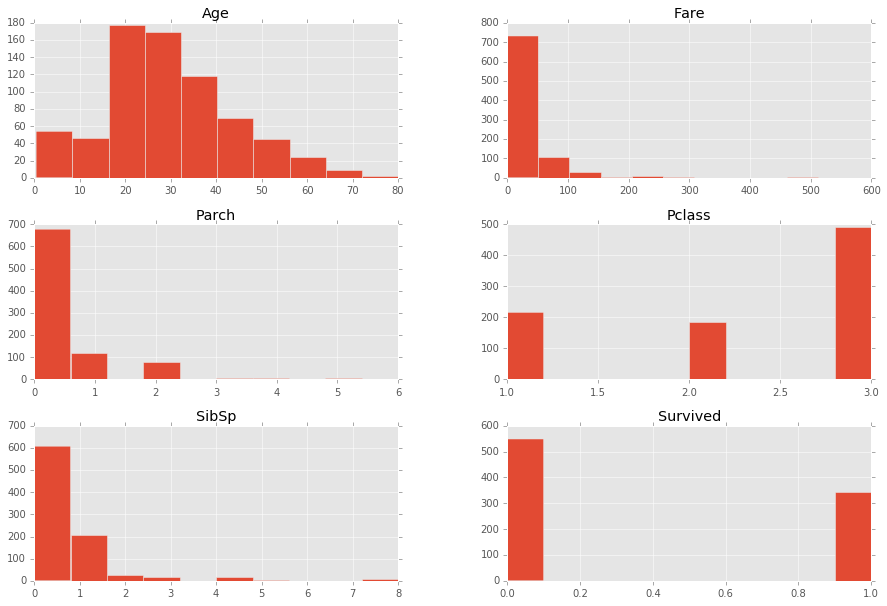

In [6]:
# there are some missing values in Age. But first check the distribution with histogram
df.hist(figsize=(15,10
                ))

In [7]:
# df.plot(kind='box', return_type='dict' , subplots = True, figsize=(15,5))

In [8]:
""" clustering using K-Means
from sklearn.cluster import KMeans
ages = df['Age'].dropna()
ages = ages.reshape(714,1)
kmeans = KMeans(n_clusters=4, random_state=0).fit(ages)
kmeans.cluster_centers_
"""

" clustering using K-Means\nfrom sklearn.cluster import KMeans\nages = df['Age'].dropna()\nages = ages.reshape(714,1)\nkmeans = KMeans(n_clusters=4, random_state=0).fit(ages)\nkmeans.cluster_centers_\n"

In [9]:
# fill the missing values in Age
median_age = df.Age.median()
df['Age'].fillna(median_age, inplace = True)

In [10]:
df.apply(lambda x: x.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [11]:
df[df.Embarked.isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
61,1,1,"Icard, Miss. Amelie",female,38.0,0,0,80.0,NaN
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,80.0,NaN


In [12]:
# check Embarked values
df.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

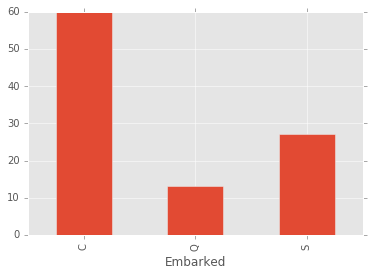

In [13]:
df.pivot_table(values='Fare',
               index=['Embarked'],
               aggfunc=np.mean).plot(kind='bar')

In [14]:
# it seems that based on Fare-Embarked relation, the missing values are likely C.
df.Embarked.fillna('C', inplace=True)

In [15]:
df.Embarked = df.Embarked.astype(str).map({"S":0,"C":1,"Q":2})

In [16]:
df.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [17]:
df['FamilySize'] = df['SibSp'] + df['Parch']


In [18]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,1,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,0,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,0,1
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,0,0


In [19]:
df['Person'] = df[['Age','Sex']].apply(lambda x: 'child' if x[0]<16 else x[1], axis=1)
# first convert to str, then map
df.Person = df.Person.astype(str).map({'male':1,'female':0,'child':2})


In [20]:
# according to the women and child first policy,
# if the wife died, it is likely the whole family died
# and if the husband died, it is likely the whole family survived

# theoretically a great tree based algorithm should discover this on its own, but
# new features like these are provided to ML as cue to narrow its search

df['surname'] = df['Name'].apply(lambda name: name.split(',')[0].lower())

perishing_female_surnames = df[(df.Person==0) & (df.Survived ==0) & (df.FamilySize > 0)]['surname'].unique()
print('Total female adult victims with family:', len(perishing_female_surnames))

('Total female adult victims with family:', 30)


In [21]:
df['perish_mother_wife'] = df['surname'].apply(lambda x: 1 if x in perishing_female_surnames else 0)


In [22]:
survive_male_surnames = df[(df.Person==1) & (df.Survived ==1) & (df.FamilySize > 0)]['surname'].unique()

In [23]:
df['survive_father_husband'] = df['surname'].apply(lambda x: 1 if x in survive_male_surnames else 0)


In [24]:
# finish up and predict

df.drop(['SibSp','Parch','Name','surname','Sex','Age'],axis=1, inplace=True)
df.columns

Index([u'Survived', u'Pclass', u'Fare', u'Embarked', u'FamilySize', u'Person',
       u'perish_mother_wife', u'survive_father_husband'],
      dtype='object')

In [25]:
predictor_var = list(df.columns[1:]) ;predictor_var
outcome_var = 'Survived'

In [26]:
categorical = ['Pclass', 'Person','Embarked','perish_mother_wife','survive_father_husband']
non_categorical = [ i for i in predictor_var if i not in categorical ]

In [27]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_cat = ohe.fit_transform(df[categorical])

In [28]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_non_cat = sc.fit_transform(df[non_categorical])

In [29]:
from numpy import hstack
X = hstack((X_non_cat, X_cat))
y = df[outcome_var]
X.shape, X_non_cat.shape, X_cat.shape

((891, 15), (891, 2), (891, 13))

In [30]:
from sklearn.model_selection import learning_curve
# http://scikit-learn.org/stable/modules/generated\
#/sklearn.model_selection.learning_curve.html#sklearn.model_selection.learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
scores = cross_val_score(lr_model, X, y, cv=10, scoring='accuracy')
print "Accuracy: {:.3%} +/-{:.2%} lr_model".format(scores.mean(), scores.std())

Accuracy: 88.656% +/-2.47% lr_model


In [32]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=300, max_depth=6)
#print rf_model.get_params()
scores = cross_val_score(rf_model, X, y, cv=10, scoring='accuracy')
print "Accuracy: {:.3%} +/-{:.2%} rf_model".format(scores.mean(), scores.std())

Accuracy: 88.209% +/-2.78% rf_model


<module 'matplotlib.pyplot' from '/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

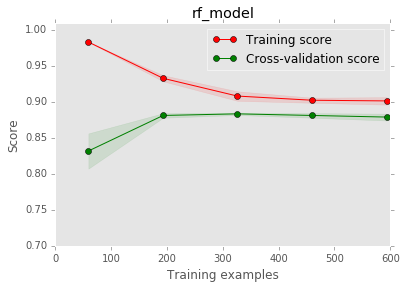

In [33]:
plot_learning_curve(rf_model, "rf_model", X, y, ylim=(0.7, 1.01), n_jobs=4)

In [34]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
print "Accuracy: {:.3%} +/-{:.2%} knn".format(scores.mean(), scores.std())

Accuracy: 86.774% +/-5.17% knn


In [35]:
from sklearn import svm
svm_model = svm.SVC(kernel='rbf', random_state=0, gamma=0.10, C=1)
scores = cross_val_score(svm_model, X, y, cv=10, scoring='accuracy')
print "Accuracy: {:.3%} +/-{:.2%} svm_model".format(scores.mean(), scores.std())

Accuracy: 88.656% +/-2.76% svm_model


<module 'matplotlib.pyplot' from '/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

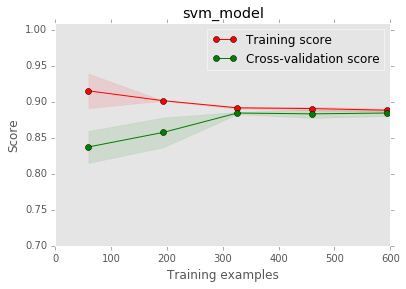

In [36]:
plot_learning_curve(svm_model, "svm_model", X, y, ylim=(0.7, 1.01), n_jobs=4)

In [37]:
from sklearn.ensemble import AdaBoostClassifier

adaboost = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(adaboost, X, y, cv=10, scoring='accuracy')
print "Accuracy: {:.2%} +/-{:.2%} adaboost".format(scores.mean(), scores.std())

Accuracy: 87.98% +/-2.63% adaboost


In [38]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
scores = cross_val_score(gnb, X, y, cv=10, scoring='accuracy')
print "Accuracy: {:.3%} +/-{:.2%} GaussianNB".format(scores.mean(), scores.std())

Accuracy: 85.524% +/-2.52% GaussianNB


In [39]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

xgb = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.9,
 colsample_bytree=0.9,
 #reg_alpha = .01,
 #reg_lambda = .01,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=555)
scores = cross_val_score(xgb, X, y, cv=10, scoring='accuracy')
print "Accuracy: {:.3%} +/-{:.2%} xgb".format(scores.mean(), scores.std())

/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Accuracy: 88.656% +/-2.98% xgb


In [40]:
from sklearn.ensemble import VotingClassifier
eclf = VotingClassifier(estimators=[('rf', rf_model), ('svm', svm_model),('adaboost', adaboost)], voting='hard')

scores = cross_val_score(eclf, X, y, cv=10, scoring='accuracy')
print "Accuracy: {:.3%} +/-{:.2%} eclf".format(scores.mean(), scores.std())

Accuracy: 88.769% +/-2.83% eclf


In [41]:
""" really slow
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier(rf_model,
                            max_samples=0.5, max_features=0.5)
scores = cross_val_score(bagging, X, y, cv=10, scoring='accuracy')
print "Accuracy: {:.2%} +/-{:.2%} bagging".format(scores.mean(), scores.std())
"""

' really slow\nfrom sklearn.ensemble import BaggingClassifier\n\nbagging = BaggingClassifier(rf_model,\n                            max_samples=0.5, max_features=0.5)\nscores = cross_val_score(bagging, X, y, cv=10, scoring=\'accuracy\')\nprint "Accuracy: {:.2%} +/-{:.2%} bagging".format(scores.mean(), scores.std())\n'

In [42]:
"""
from sklearn.grid_search import GridSearchCV   #Perforing grid search

param_test1 = {
    #'C':(1e-5,1e-2,1,10), C=1, .826
    #'gamma':(.9,.6,.3,.1), gamma = .1
}

gsearch1 = GridSearchCV(estimator = svm.SVC(kernel='rbf', random_state=0, gamma=.1), 
 param_grid = param_test1, scoring='accuracy',n_jobs=4,cv=10, verbose=0)

gsearch1.fit(X, y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_
"""

"\nfrom sklearn.grid_search import GridSearchCV   #Perforing grid search\n\nparam_test1 = {\n    #'C':(1e-5,1e-2,1,10), C=1, .826\n    #'gamma':(.9,.6,.3,.1), gamma = .1\n}\n\ngsearch1 = GridSearchCV(estimator = svm.SVC(kernel='rbf', random_state=0, gamma=.1), \n param_grid = param_test1, scoring='accuracy',n_jobs=4,cv=10, verbose=0)\n\ngsearch1.fit(X, y)\ngsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_\n"

In [43]:

from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.cross_validation import train_test_split

"""
def modelfit(alg, X, y, useTrainCV=True, cv_folds=5, early_stopping_rounds=10):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        dtrain = xgb.DMatrix(X,label=y)
        cvresult = xgb.cv(xgb_param,
                          dtrain,
                          num_boost_round=alg.get_params()['n_estimators'],
                          nfold=cv_folds,
                          metrics='error', # no accuracy
                          callbacks=[xgb.callback.print_evaluation(show_stdv=False),
                                     xgb.callback.early_stop(early_stopping_rounds)]
                         )
        
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X, y,eval_metric='error')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(y.values, dtrain_predictions)
    #print "AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 #reg_alpha = .01,
 #reg_lambda = .01,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=555)

#modelfit(xgb1, X, y)
"""

/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


'\ndef modelfit(alg, X, y, useTrainCV=True, cv_folds=5, early_stopping_rounds=10):\n    if useTrainCV:\n        xgb_param = alg.get_xgb_params()\n        dtrain = xgb.DMatrix(X,label=y)\n        cvresult = xgb.cv(xgb_param,\n                          dtrain,\n                          num_boost_round=alg.get_params()[\'n_estimators\'],\n                          nfold=cv_folds,\n                          metrics=\'error\', # no accuracy\n                          callbacks=[xgb.callback.print_evaluation(show_stdv=False),\n                                     xgb.callback.early_stop(early_stopping_rounds)]\n                         )\n        \n        alg.set_params(n_estimators=cvresult.shape[0])\n    \n    #Fit the algorithm on the data\n    alg.fit(X, y,eval_metric=\'error\')\n        \n    #Predict training set:\n    dtrain_predictions = alg.predict(X)\n    dtrain_predprob = alg.predict_proba(X)[:,1]\n        \n    #Print model report:\n    print "\nModel Report"\n    print "Accura

In [44]:
# now work on test data
test_df.apply(lambda x: x.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [45]:
test_df.Age.fillna(test_df.Age.median(), inplace=True)

In [46]:
test_df[test_df.Fare.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [47]:
test_df.Embarked = test_df.Embarked.astype(str).map({"S":0,"C":1,"Q":2})

In [48]:
mean_fare = test_df[test_df.Embarked==0]['Fare'].mean() ; mean_fare

28.230436431226767

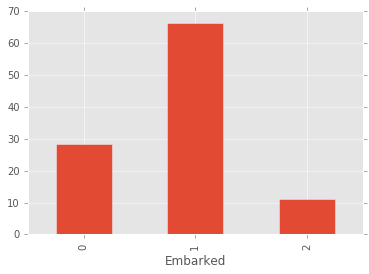

In [49]:
test_df.pivot_table(values='Fare',
               index=['Embarked'],
               aggfunc=np.mean).plot(kind='bar')

In [50]:
test_df.Fare.fillna(mean_fare, inplace = True)

In [51]:
test_df['FamilySize'] = test_df.SibSp + test_df.Parch


In [52]:
test_df['Person'] = test_df[['Age','Sex']].apply(lambda x: 'child' if x[0]<16 else x[1], axis=1)
# first convert to str, then map
test_df.Person = test_df.Person.astype(str).map({'male':1,'female':0,'child':2})


In [53]:
# additional features

test_df['surname'] = test_df['Name'].apply(lambda name: name.split(',')[0].lower())

test_df['perish_mother_wife'] = test_df['surname'].apply(lambda x: 1 if x in perishing_female_surnames else 0)
test_df['survive_father_husband'] = test_df['surname'].apply(lambda x: 1 if x in survive_male_surnames else 0)


In [54]:
test_df.drop(['Name','surname','Sex','Age','SibSp','Parch','Ticket','Cabin'], inplace=True, axis=1)
test_df[:3]

,PassengerId,Pclass,Fare,Embarked,FamilySize,Person,perish_mother_wife,survive_father_husband
0,892,3,7.8292,2,0,1,0,0
1,893,3,7.0000,0,1,0,0,0
2,894,2,9.6875,2,0,1,0,0


In [55]:
# encoding, standarize
X_test_cat = ohe.transform(test_df[categorical])
X_test_non_cat = sc.transform(test_df[non_categorical])
X_test = hstack((X_test_non_cat, X_test_cat))

In [56]:
model = rf_model
model.fit(X,y)
Y_pred = model.predict(X_test)
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('./submissions/rf6.csv', index=False)

In [57]:
#-------------------------------------------------------
# model: score, description
#-------------------------------------------------------
# SVM1: .79426
# SVM2: .78469. use FamilySize instead of SibSp, Parch
# SVM3: .79426. Use both. no improvement
# SVM4: .79426, map sex, age to person
# xgb1, rf1 : not as good as svm1
# dt1,  .76077
# lr1: .76077, trees = 100, depth = 5
# rf2: .77512, n_estimator=300, maxdepth = 6
# rf3: .78469, n_estimator=300, maxdepth = 6, change from fit_transform to transform to generate X_test
# rf4: .79426, map sex, age to person
# rf5: .80861, use familysize instead of sibsp, parch
# xgb2: .78469, use the same config as rf5.
# ensemble1: .79426 (lr,rf,svm, hard)
# ensemble2: .79426 (rf, svm, hard)
# ensemble3: .78947 (rf, svm, adaboost, hard)